# EECE 7398: Verifiable Machine Learning -- Fall 2024
# Exercise #1: Adversarial Examples & Decision Boundaries

**Submission Instructions:** Please upload a .ipynb file (including your code, plots, and written answers) to Gradescope. This file can be updated unlimited times until the submission deadline.

# Problem 1: Train & Attack an MNIST Classifier

## 1a) Train an MNIST Classifier

To start, train a NN classifier that consists of:
- a "Flatten" layer to convert the (28, 28) images to (784,)
- a fully connected layer with 128 neurons and ReLU activation
- a fully connected (output) layer with 10 neurons (10 neurons for 10 digit categories)
- (optionally) a softmax layer to convert logits to probabilities

You can use the Adam optimizer with cross entropy loss (make sure to use the correct loss depending on whether you included a softmax layer) and it should work pretty well.

**Deliverables**:
- Plot your train and validation loss curves as a function of epoch
- From a test set, provide some examples where your classifier predicted correctly & incorrectly (if applicable)

11490434/11490434 [==============================] - 2s 0us/step
Epoch 1/100
1594/1594 [==============================] - 8s 4ms/step - loss: 0.2790 - accuracy: 0.9203 - val_loss: 0.1504 - val_accuracy: 0.9581
Epoch 2/100
1594/1594 [==============================] - 5s 3ms/step - loss: 0.1260 - accuracy: 0.9628 - val_loss: 0.1071 - val_accuracy: 0.9676
Epoch 3/100
1594/1594 [==============================] - 6s 3ms/step - loss: 0.0845 - accuracy: 0.9745 - val_loss: 0.0877 - val_accuracy: 0.9728
Epoch 4/100
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0625 - accuracy: 0.9813 - val_loss: 0.0841 - val_accuracy: 0.9757
Epoch 5/100
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0478 - accuracy: 0.9848 - val_loss: 0.0805 - val_accuracy: 0.9751
Epoch 6/100
1594/1594 [==============================] - 5s 3ms/step - loss: 0.0382 - accuracy: 0.9882 - val_loss: 0.0800 - val_accuracy: 0.9778
Epoch 7/100
1594/1594 [==============================] - 5s 3ms/s

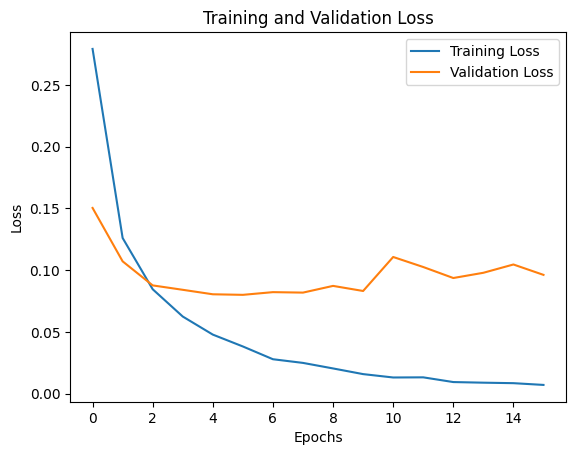

313/313 [==============================] - 1s 1ms/step


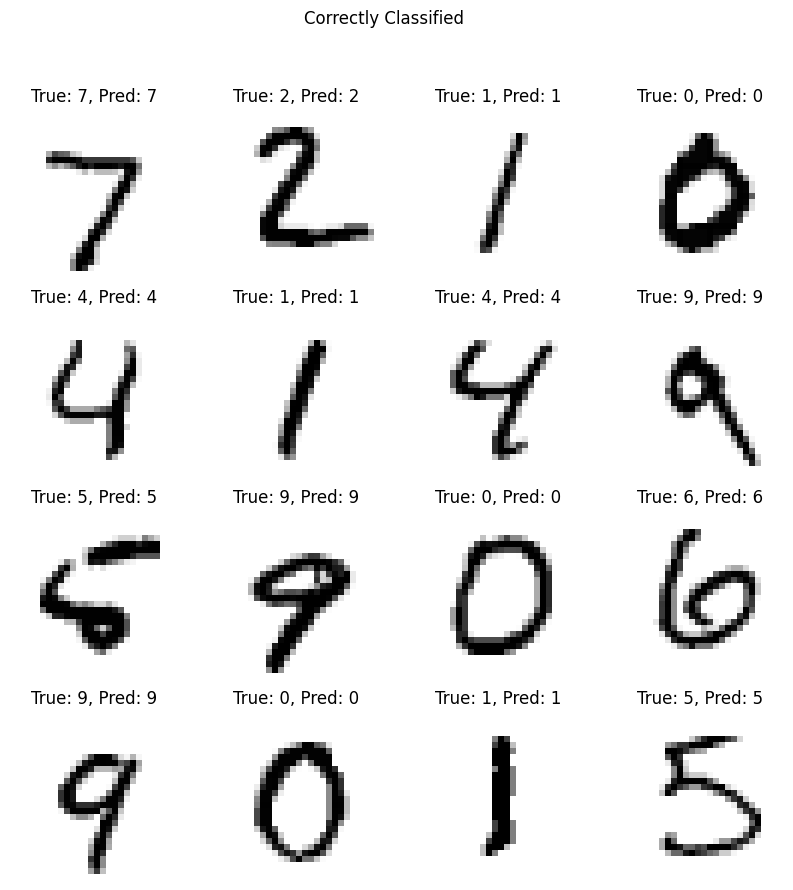

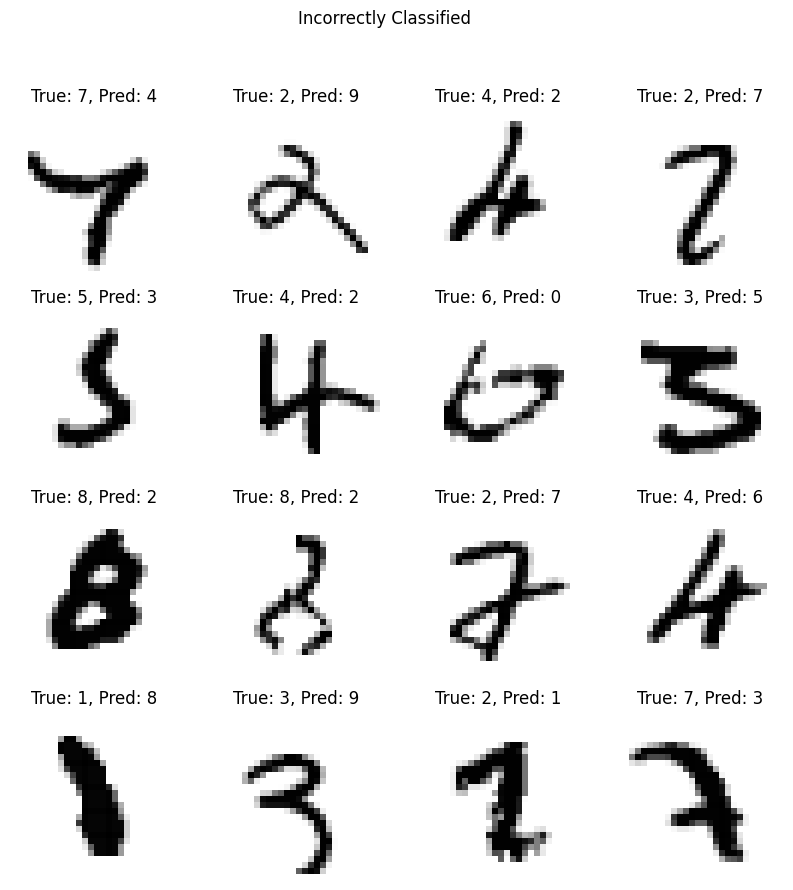

In [48]:

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# load the dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# convert to one
x_train, x_test = x_train / 255.0, x_test / 255.0

# create the model
def create_model():
    model = models.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(128, activation='relu'),
        layers.Dense(10),
        layers.Softmax()
    ])
    return model

model = create_model()

# compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# add the early stopping so that the validation will not overshot
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# train the model
history = model.fit(x_train, y_train,
                    validation_split=0.15,
                    epochs=100,
                    callbacks=[early_stopping_callback])

# plot
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# test the model
predictions = model.predict(x_test)

# show the right and wrong cases
def plot_images(images, labels, preds, title):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.title(f"True: {labels[i]}, Pred: {preds[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

#get teh prediction
correct_preds = np.where(np.argmax(predictions, axis=1) == y_test)[0]
incorrect_preds = np.where(np.argmax(predictions, axis=1) != y_test)[0]

plot_images(x_test[correct_preds][:16], y_test[correct_preds][:16], np.argmax(predictions, axis=1)[correct_preds][:16], 'Correctly Classified')

plot_images(x_test[incorrect_preds][:16], y_test[incorrect_preds][:16], np.argmax(predictions, axis=1)[incorrect_preds][:16], 'Incorrectly Classified')


## 1b) Attack your MNIST classifier with constant offsets

Add a constant perturbation to your test set images (e.g., c*torch.ones(28, 28)) and evaluate the performance as the magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- Provide some examples where the un-perturbed image was labeled correctly and the perturbed image was labeled incorrectly, despite the perturbed image looking reasonable to a human.

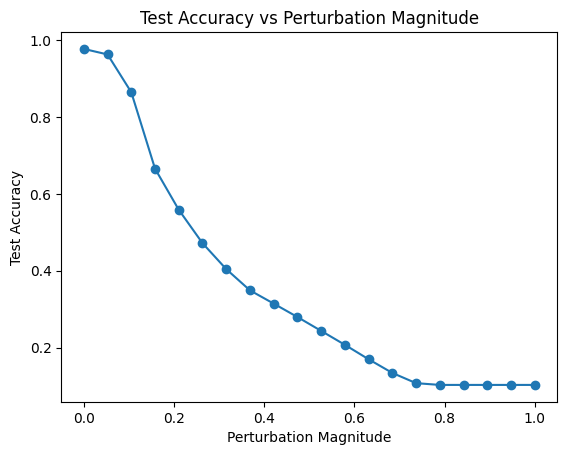

313/313 [==============================] - 1s 2ms/step


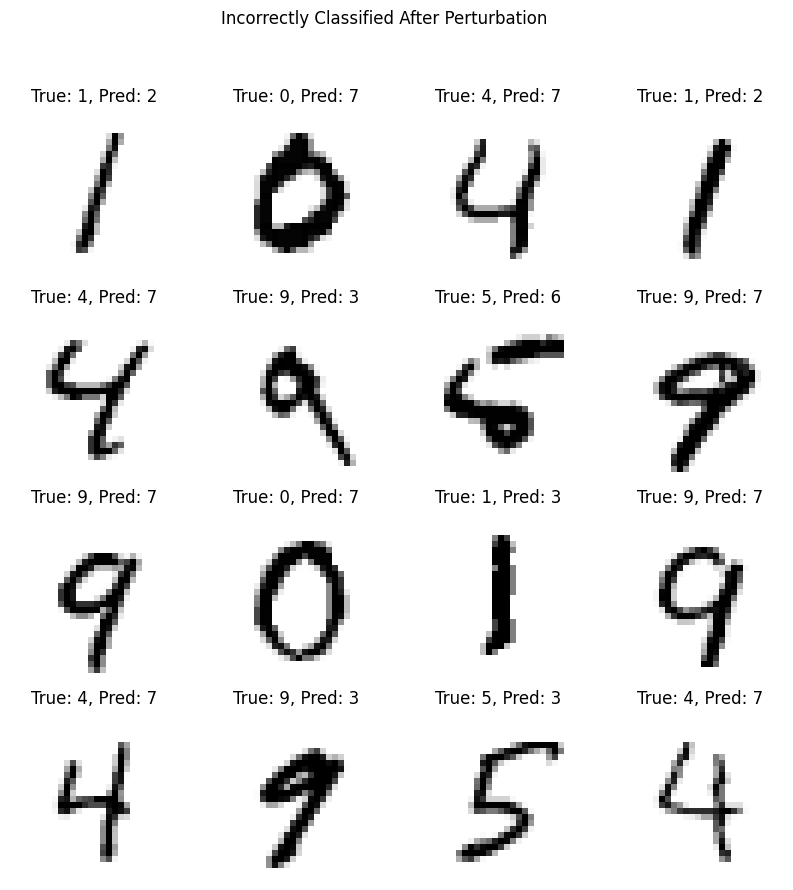

In [49]:

def add_perturbation(images, magnitude):
    # add constant perturbation
    perturbed_images = images + magnitude * np.ones_like(images)
    # resize the img
    perturbed_images = np.clip(perturbed_images, 0, 1)
    return perturbed_images

# test
perturbation_magnitudes = np.linspace(0, 1, 20)
accuracies = []

for magnitude in perturbation_magnitudes:
    perturbed_x_test = add_perturbation(x_test, magnitude)
    test_loss, test_acc = model.evaluate(perturbed_x_test, y_test, verbose=0)
    accuracies.append(test_acc)

# plot
plt.plot(perturbation_magnitudes, accuracies, marker='o')
plt.title('Test Accuracy vs Perturbation Magnitude')
plt.xlabel('Perturbation Magnitude')
plt.ylabel('Test Accuracy')
plt.show()

# show wrong cases
perturbation_magnitude = 0.3  # validation magnitude
perturbed_x_test = add_perturbation(x_test, perturbation_magnitude)
predictions = np.argmax(model.predict(perturbed_x_test), axis=1)

# right or wrong imgs
incorrect_preds = np.where(predictions != y_test)[0]

# plot
def plot_images(images, labels, preds, title):
    plt.figure(figsize=(10, 10))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.title(f"True: {labels[i]}, Pred: {preds[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

plot_images(x_test[incorrect_preds][:16], y_test[incorrect_preds][:16], predictions[incorrect_preds][:16], 'Incorrectly Classified After Perturbation')


## 1c) Attack your MNIST classifier with noise

Add some noise perturbations to your test set images and evaluate the performance as the noise magnitude increases. Also, be sure to clip your perturbed images so each pixel remains in [0, 1] (or [0, 255]).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about any differences observed with constant perturbations vs. noise perturbations

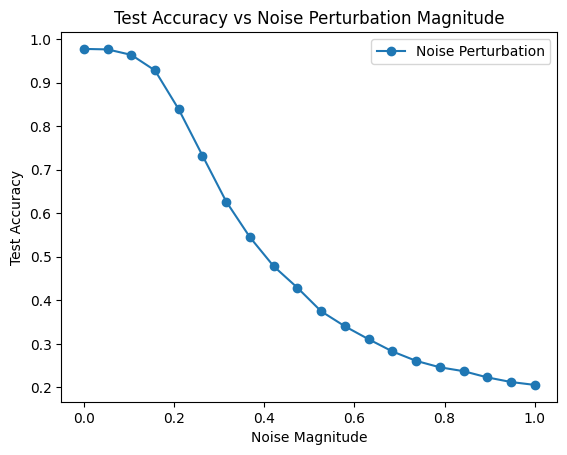

313/313 [==============================] - 0s 1ms/step


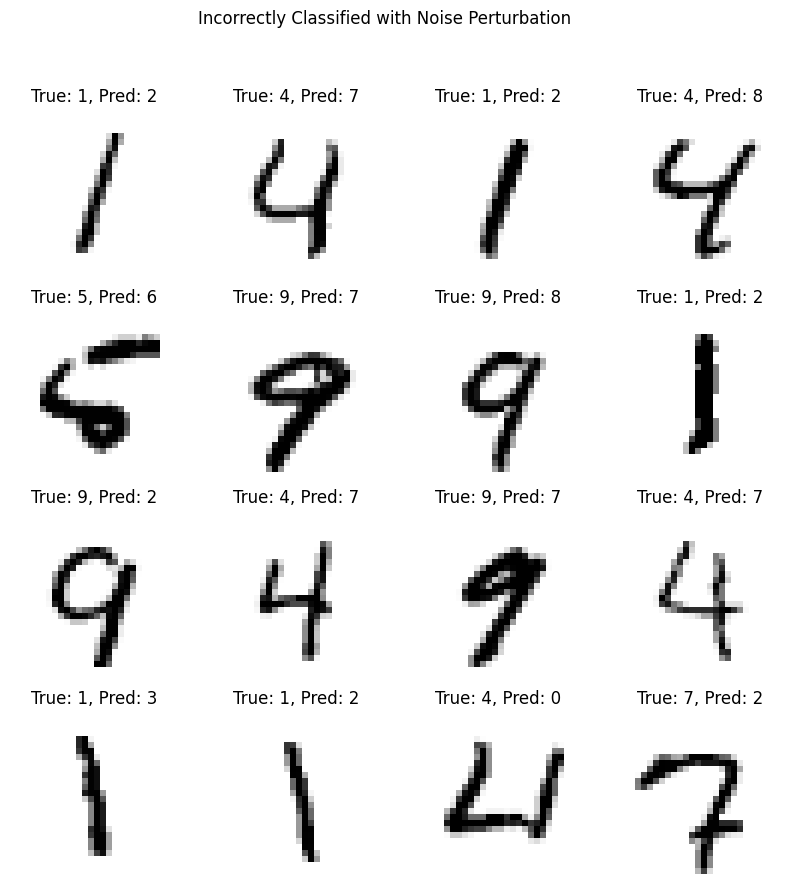

In [50]:
import numpy as np

# Define a function to add noise perturbation
def add_noise_perturbation(images, magnitude):
    """
    Add random noise perturbation to the images.
    The noise is drawn from a normal distribution.
    """
    noise = np.random.normal(0, magnitude, images.shape)  # Generate noise with given magnitude
    perturbed_images = images + noise  # Add noise to images
    perturbed_images = np.clip(perturbed_images, 0, 1)  # Clip the pixel values to remain within [0, 1]
    return perturbed_images

# Evaluate test accuracy as a function of noise magnitude
noise_magnitudes = np.linspace(0, 1, 20)  # Noise magnitude from 0 to 1
accuracies_noise = []

for magnitude in noise_magnitudes:
    perturbed_x_test_noise = add_noise_perturbation(x_test, magnitude)
    test_loss, test_acc = model.evaluate(perturbed_x_test_noise, y_test, verbose=0)
    accuracies_noise.append(test_acc)

# Plot the test accuracy as a function of the noise magnitude
plt.plot(noise_magnitudes, accuracies_noise, marker='o', label='Noise Perturbation')
plt.title('Test Accuracy vs Noise Perturbation Magnitude')
plt.xlabel('Noise Magnitude')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

# Display some examples of correctly classified images without noise and misclassified with noise
perturbation_magnitude = 0.3  # Choose a reasonable noise magnitude
perturbed_x_test_noise = add_noise_perturbation(x_test, perturbation_magnitude)
predictions_noise = np.argmax(model.predict(perturbed_x_test_noise), axis=1)

# Find incorrectly classified examples due to noise
incorrect_preds_noise = np.where(predictions_noise != y_test)[0]

# Display incorrectly classified noisy images
plot_images(x_test[incorrect_preds_noise][:16], y_test[incorrect_preds_noise][:16], predictions_noise[incorrect_preds_noise][:16], 'Incorrectly Classified with Noise Perturbation')


## 1d) Attack your MNIST classifier with FGSM

Implement the Fast Gradient Sign Method (FGSM) attack algorithm and experiment with different values of $\epsilon$. You should write FGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements FGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude
- A couple sentences about how this curve compares to the constant perturbations and noise perturbations (hopefully, FGSM should be able to achieve lower test accuracy for the same attack magnitude as those model-agnostic attacks)

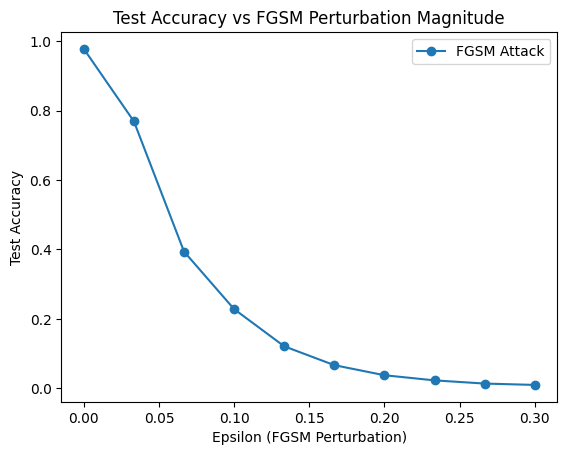

313/313 [==============================] - 1s 1ms/step


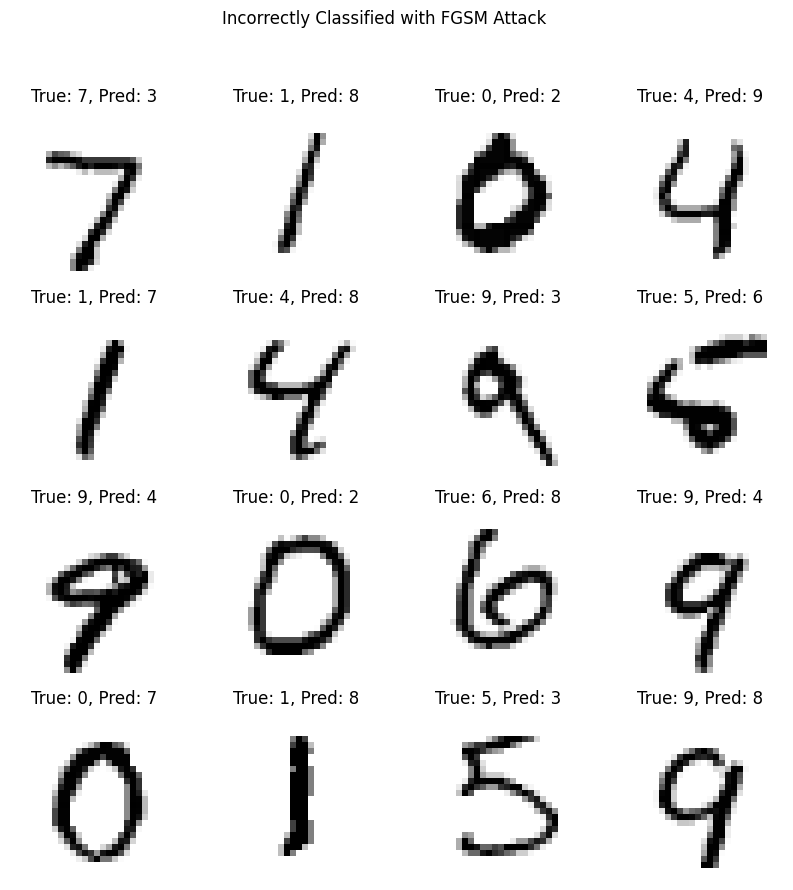

In [51]:
import tensorflow as tf
import numpy as np

# Define the FGSM attack function
def fgsm_attack(images, labels, epsilon, model):
    """
    Perform the Fast Gradient Sign Method (FGSM) attack.
    This function computes the gradient of the loss with respect to the input image
    and perturbs the image in the direction that increases the loss.
    """
    # Ensure that the input images are converted to TensorFlow tensors
    images = tf.convert_to_tensor(images)
    labels = tf.convert_to_tensor(labels)

    # Record the operations for automatic differentiation
    with tf.GradientTape() as tape:
        tape.watch(images)  # Watch the input image
        predictions = model(images)  # Get the model predictions
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)  # Compute the loss

    # Compute the gradient of the loss with respect to the image
    gradient = tape.gradient(loss, images)
    # Get the sign of the gradient
    signed_grad = tf.sign(gradient)
    # Apply the perturbation with epsilon
    perturbed_images = images + epsilon * signed_grad
    # Clip the images to ensure pixel values remain in [0, 1]
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images


# Evaluate test accuracy as a function of FGSM perturbation magnitude
epsilons = np.linspace(0, 0.3, 10)  # Define a range of epsilon values
accuracies_fgsm = []

for epsilon in epsilons:
    # Apply FGSM attack
    perturbed_x_test_fgsm = fgsm_attack(x_test, y_test, epsilon, model)
    # Evaluate the model on the perturbed images
    test_loss, test_acc = model.evaluate(perturbed_x_test_fgsm, y_test, verbose=0)
    accuracies_fgsm.append(test_acc)

# Plot the test accuracy as a function of epsilon (perturbation magnitude)
plt.plot(epsilons, accuracies_fgsm, marker='o', label='FGSM Attack')
plt.title('Test Accuracy vs FGSM Perturbation Magnitude')
plt.xlabel('Epsilon (FGSM Perturbation)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

# Display some examples of correctly classified images without FGSM and misclassified with FGSM
epsilon = 0.2  # Select a specific epsilon for demonstration
perturbed_x_test_fgsm = fgsm_attack(x_test, y_test, epsilon, model)
predictions_fgsm = np.argmax(model.predict(perturbed_x_test_fgsm), axis=1)

# Find incorrectly classified examples due to FGSM
incorrect_preds_fgsm = np.where(predictions_fgsm != y_test)[0]

# Display incorrectly classified FGSM images
plot_images(x_test[incorrect_preds_fgsm][:16], y_test[incorrect_preds_fgsm][:16], predictions_fgsm[incorrect_preds_fgsm][:16], 'Incorrectly Classified with FGSM Attack')


After epsiolon = 0.15, the model's accuracy approaches to 0 which means FGSM is very effective. comparing to the constant and noise perturbations. It goes down very quictly.

## 1e) Attack your MNIST classifier with Targeted FGSM

Implement the Targeted Fast Gradient Sign Method (TFGSM) attack algorithm and experiment with different values of $\epsilon$. You should write TFGSM "from scratch" (e.g., using pytorch/numpy to evaluate the gradient, not using a library/method that already implements TFGSM).

**Deliverables**:
- Plot your test accuracy as a function of the perturbation magnitude for each target class
- A few example images where you were able to successfully cause the classifier to predict the targeted (incorrect) class
- A few sentences about your model's susceptibility to targeted attacks (e.g., are some target classes "easier" to get your model to classify? if you try to perturb images labeled 0 to a target class of 8, does the image get perturbed in an intuitive way?)

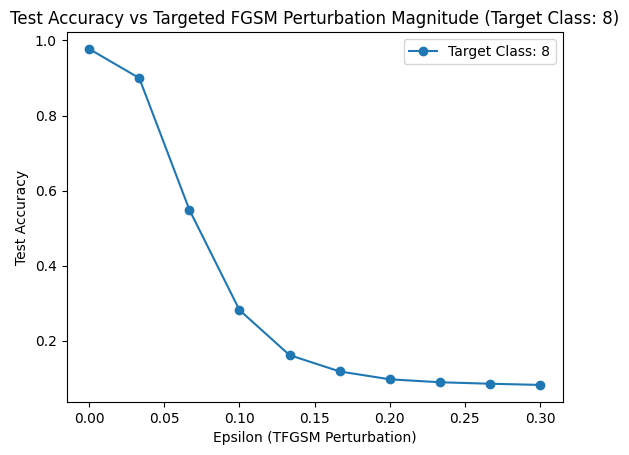

313/313 [==============================] - 1s 2ms/step


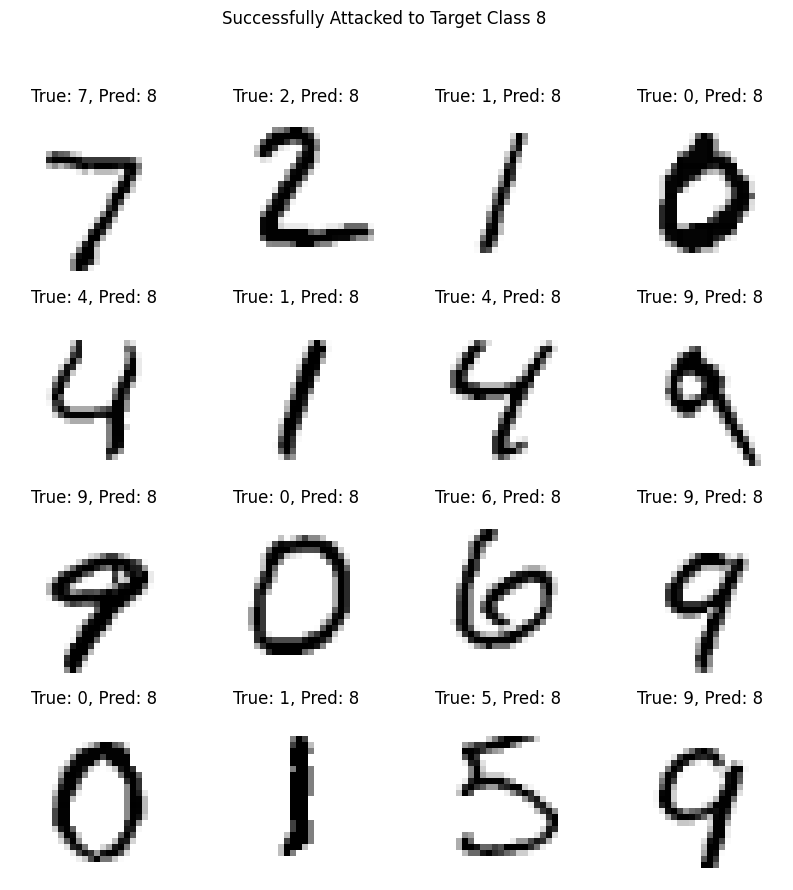

In [52]:
import tensorflow as tf
import numpy as np

# Define the Targeted FGSM attack function
def targeted_fgsm_attack(images, true_labels, target_labels, epsilon, model):
    """
    Perform the Targeted Fast Gradient Sign Method (TFGSM) attack.
    This function computes the gradient of the loss with respect to the input image
    and perturbs the image in the direction that minimizes the loss for a target class.
    """
    # Convert images and labels to TensorFlow tensors
    images = tf.convert_to_tensor(images)
    true_labels = tf.convert_to_tensor(true_labels)
    target_labels = tf.convert_to_tensor(target_labels)

    with tf.GradientTape() as tape:
        tape.watch(images)  # Watch the input image
        predictions = model(images)  # Get the model predictions
        loss = tf.keras.losses.sparse_categorical_crossentropy(target_labels, predictions)  # Targeted loss

    # Compute the gradient of the loss with respect to the image
    gradient = tape.gradient(loss, images)
    # Get the sign of the gradient (move toward minimizing the target loss)
    signed_grad = tf.sign(gradient)
    # Apply the perturbation with epsilon
    perturbed_images = images - epsilon * signed_grad  # Subtract to minimize loss for target class
    # Clip the images to ensure pixel values remain in [0, 1]
    perturbed_images = tf.clip_by_value(perturbed_images, 0, 1)
    return perturbed_images

# Define a range of epsilon values and target classes
epsilons = np.linspace(0, 0.3, 10)  # Epsilon values from 0 to 0.3
target_class = 8  # Target class for the attack
accuracies_targeted_fgsm = []

# Evaluate test accuracy for targeted FGSM on each epsilon
for epsilon in epsilons:
    # Create targeted labels (forcing the model to predict a specific target class, e.g., 8)
    target_labels = np.full_like(y_test, target_class)
    # Apply Targeted FGSM attack
    perturbed_x_test_tfgsm = targeted_fgsm_attack(x_test, y_test, target_labels, epsilon, model)
    # Evaluate the model on the perturbed images
    test_loss, test_acc = model.evaluate(perturbed_x_test_tfgsm, y_test, verbose=0)
    accuracies_targeted_fgsm.append(test_acc)

# Plot the test accuracy as a function of epsilon for the targeted attack
plt.plot(epsilons, accuracies_targeted_fgsm, marker='o', label=f'Target Class: {target_class}')
plt.title(f'Test Accuracy vs Targeted FGSM Perturbation Magnitude (Target Class: {target_class})')
plt.xlabel('Epsilon (TFGSM Perturbation)')
plt.ylabel('Test Accuracy')
plt.legend()
plt.show()

# Display some examples of successfully targeted attacks
epsilon = 0.2  # Select a specific epsilon for demonstration
perturbed_x_test_tfgsm = targeted_fgsm_attack(x_test, y_test, target_labels, epsilon, model)
predictions_tfgsm = np.argmax(model.predict(perturbed_x_test_tfgsm), axis=1)

# Find examples where the model predicts the targeted class
targeted_success = np.where(predictions_tfgsm == target_class)[0]

# Display images where the attack successfully changed the prediction to the target class
plot_images(x_test[targeted_success][:16], y_test[targeted_success][:16], predictions_tfgsm[targeted_success][:16], f'Successfully Attacked to Target Class {target_class}')


In the case of Targeted FGSM attacks, the model shows significant susceptibility, as seen in the rapid drop in accuracy with increasing perturbation magnitude.

# Problem 2: Investigating Decision Boundaries

In this problem, you will train a binary classifier for a 2D input vector (is the (x, y) coordinate inside a circle of radius r centered at the origin?).

Since you will know the true decision boundary that the model is trained to approximate, you can generate training data.

Then, you will investigate the model's decision boundary to see how well it matches the true decision boundary.

## 2a) Generate training data

For $x\in R^2$, using the decision rule $f(x) = \begin{cases} 1, &\lvert\lvert x \rvert\rvert_2 \leq 3 \\ 0, & \text{o.w.} \end{cases}$, generate a training, validation, and test set of $[x, f(x)]$ pairs.

**Deliverables:**
- Plot your training set and the true decision boundary

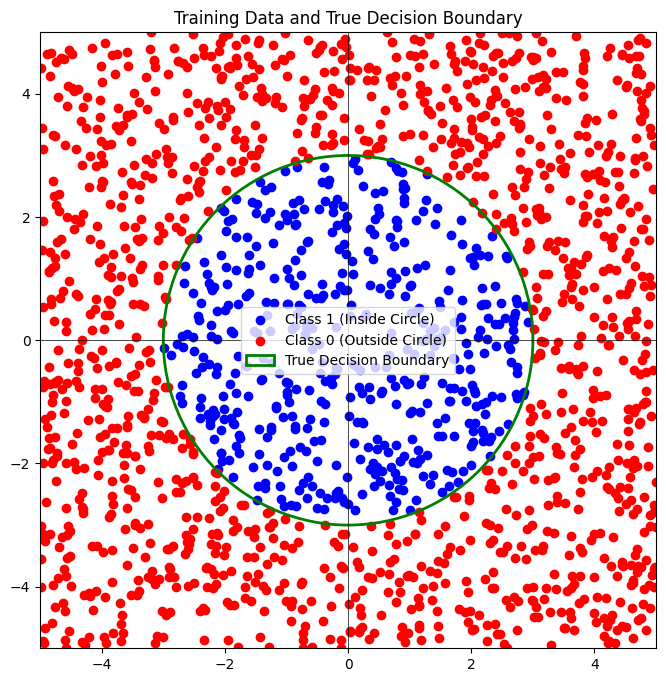

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Define the decision rule f(x): checks whether point (x, y) is inside the circle with radius 3
def decision_rule(x):
    return np.where(np.linalg.norm(x, axis=1) <= 3, 1, 0)

# Generate the dataset
np.random.seed(0)  # Set random seed for reproducibility
num_points = 3000  # Generate 3000 data points
x_data = np.random.uniform(-5, 5, (num_points, 2))  # Randomly generate points in the range [-5, 5]
y_data = decision_rule(x_data)  # Generate labels according to the decision rule

# Split data into training, validation, and test sets
train_size = int(0.6 * num_points)  # 60% for training
val_size = int(0.2 * num_points)    # 20% for validation
test_size = num_points - train_size - val_size  # Remaining 20% for testing

x_train, y_train = x_data[:train_size], y_data[:train_size]
x_val, y_val = x_data[train_size:train_size + val_size], y_data[train_size:train_size + val_size]
x_test, y_test = x_data[train_size + val_size:], y_data[train_size + val_size:]

# Plot the training data and the true decision boundary
plt.figure(figsize=(8, 8))

# Plot training data points, using different colors to represent class 0 and class 1
plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='blue', label='Class 1 (Inside Circle)')
plt.scatter(x_train[y_train == 0][:, 0], x_train[y_train == 0][:, 1], color='red', label='Class 0 (Outside Circle)')

# Plot the true decision boundary (a circle with radius 3)
circle = plt.Circle((0, 0), 3, color='green', fill=False, linewidth=2, label='True Decision Boundary')
plt.gca().add_artist(circle)

# Set plot parameters
plt.xlim([-5, 5])
plt.ylim([-5, 5])
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.gca().set_aspect('equal', adjustable='box')  # Keep the aspect ratio equal for x and y axes
plt.title('Training Data and True Decision Boundary')
plt.legend()
plt.show()


## 2b) Train NN classifier

Train a NN classifier on the data you just generated.

**Deliverables**:
- Plot your train & validation loss curves as a function of epoch

Epoch 1/100
57/57 [==============================] - 3s 10ms/step - loss: 0.4447 - accuracy: 0.7306 - val_loss: 0.4484 - val_accuracy: 0.7083
Epoch 2/100
57/57 [==============================] - 0s 6ms/step - loss: 0.3966 - accuracy: 0.7433 - val_loss: 0.4066 - val_accuracy: 0.7317
Epoch 3/100
57/57 [==============================] - 0s 7ms/step - loss: 0.3459 - accuracy: 0.7856 - val_loss: 0.3374 - val_accuracy: 0.8000
Epoch 4/100
57/57 [==============================] - 0s 6ms/step - loss: 0.2630 - accuracy: 0.8689 - val_loss: 0.2343 - val_accuracy: 0.9200
Epoch 5/100
57/57 [==============================] - 0s 6ms/step - loss: 0.1740 - accuracy: 0.9522 - val_loss: 0.1513 - val_accuracy: 0.9517
Epoch 6/100
57/57 [==============================] - 0s 5ms/step - loss: 0.1200 - accuracy: 0.9733 - val_loss: 0.1095 - val_accuracy: 0.9833
Epoch 7/100
57/57 [==============================] - 0s 4ms/step - loss: 0.0929 - accuracy: 0.9783 - val_loss: 0.0927 - val_accuracy: 0.9833
Epoch 8/100


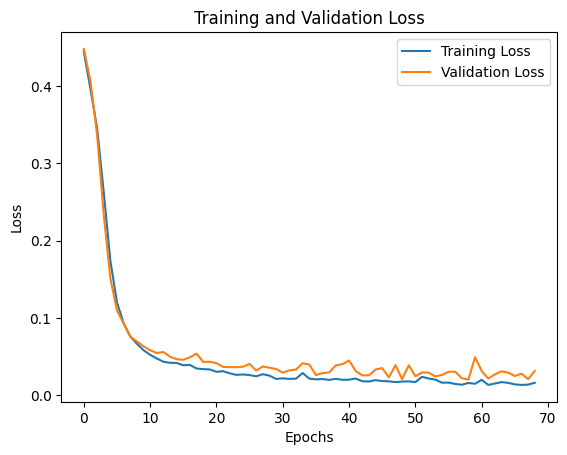

In [54]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define the neural network model
def create_nn_model():
    model = models.Sequential([
        layers.Dense(64, activation='relu', input_shape=(2,)),  # First hidden layer with 64 neurons and ReLU activation
        layers.Dense(64, activation='relu'),                    # Second hidden layer with 64 neurons and ReLU activation
        layers.Dense(1, activation='sigmoid')                   # Output layer with sigmoid activation for binary classification
    ])
    return model

# Create the neural network model
model = create_nn_model()

# Compile the model using Adam optimizer and binary crossentropy loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Use EarlyStopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Train the model and monitor training and validation loss
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=100,
                    callbacks=[early_stopping])

# Plot the training and validation loss curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## 2c) Compare decision boundaries

It is unlikely that your model has learned the true decision boundary perfectly. Here, you will investigate the differences.

**Deliverables**:
- Plot the true and learned decision boundaries
- A few sentences (with relevant figures to illustrate observations) about any differences and how changes to the model architecture or training procedure can impact decision boundaries (e.g., adding regularization, changing the training data generation method, changing the activation functions).

The model learned most of the circles but the boundary performance is not well.

11250/11250 [==============================] - 17s 2ms/step


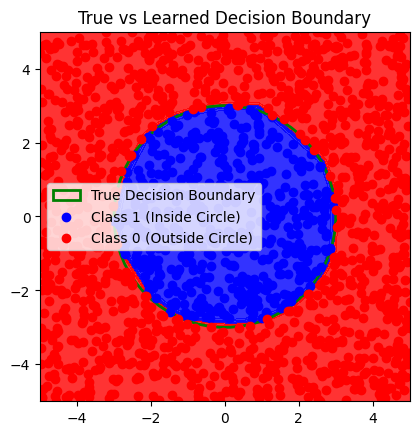

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Generate a grid of points to visualize decision boundary
def create_meshgrid(x, y, h=0.02):
    """
    Create a meshgrid for x and y for plotting decision boundaries.
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

# Predict the decision boundary of the model
def plot_decision_boundary(model, x_train, y_train):
    """
    Plot the true decision boundary and the learned decision boundary of the model.
    """
    # Create a grid over the input space
    xx, yy = create_meshgrid(x_train[:, 0], x_train[:, 1])
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Predict the decision on the grid points
    Z = model.predict(grid_points)
    Z = Z.reshape(xx.shape)

    # Plot the model's learned decision boundary
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=ListedColormap(('red', 'blue')))

    # Plot the true decision boundary (the circle with radius 3)
    circle = plt.Circle((0, 0), 3, color='green', fill=False, linewidth=2, label='True Decision Boundary')
    plt.gca().add_artist(circle)

    # Plot the training points
    plt.scatter(x_train[y_train == 1][:, 0], x_train[y_train == 1][:, 1], color='blue', label='Class 1 (Inside Circle)')
    plt.scatter(x_train[y_train == 0][:, 0], x_train[y_train == 0][:, 1], color='red', label='Class 0 (Outside Circle)')

    plt.xlim([-5, 5])
    plt.ylim([-5, 5])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('True vs Learned Decision Boundary')
    plt.legend()
    plt.show()

# Plot the decision boundaries
plot_decision_boundary(model, x_train, y_train)


# Problem 3: Attack Competition on a Pre-Trained CIFAR-10 Classifier [Extra Credit]

## 3.1 White-Box $l_\infty$-norm Attack

Here, you will have access to the full model (i.e., you know all of its parameters and architecture, you can compute gradients). You should write a function that takes in:
- the model
- a set of images + corresponding labels
- a perturbation magnitude,

and returns a perturbed version of the provided images that will cause the model to have poor classification accuracy.

We provide a template for your attack function and a function for checking the classification accuracy so that you can prototype locally. Once you upload your .ipynb to Gradescope (make sure it is named `hw1.ipynb`), we will run your attack function against some random test images and maintain a leaderboard of the strongest attack (we provide the actual evaluation script below for your convenience). Every student that gets the accuracy below 40% will get some extra credit, and the student with strongest attack will get more extra credit. In case of a tie, we will look at runtime. You can keep updating your submission until the deadline.

In [56]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import time
import importlib

Here's a suggested way of getting the CIFAR-10 dataset:

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 256

transform = transforms.Compose([transforms.ToTensor()])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


Here's the model you'll be attacking (ResNet20):

In [59]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [57]:
def white_box_attack(model, raw_images, labels, attack_magnitude, iters=10, device='cpu'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    raw_images = raw_images.to(device)
    perturbed_images = raw_images.clone().detach().requires_grad_(True)
    labels = labels.to(device)

    loss_fn = torch.nn.CrossEntropyLoss()
    original_images = raw_images.data
    alpha = attack_magnitude / iters

    for i in range(iters):
        model.zero_grad()
        outputs = model(normalize(perturbed_images))
        cost = loss_fn(outputs, labels).to(device)
        cost.backward()

        sign_gradient = perturbed_images.grad.sign()
        perturbed_images = perturbed_images + alpha * sign_gradient

        difference = torch.clamp(perturbed_images - original_images, min=-attack_magnitude, max=attack_magnitude)
        perturbed_images = torch.clamp(original_images + difference, min=0, max=1)
        perturbed_images = perturbed_images.detach().requires_grad_(True)

    return perturbed_images


While CIFAR-10 images have pixel values $\in [0, 1]$, the model we're attacking was trained on a normalized version of CIFAR-10 (i.e., each image was shifted/scaled by a mean/std). You can attack the model in the original pixel coordinates (that's the space we'll enforce the attack magnitude), but remember that any time you want to query the model, you should first normalize the images according to those settings:

In [60]:
def normalize(imgs):
    mean = (0.4914, 0.4822, 0.4465)
    std = (0.2023, 0.1994, 0.2010)
    Normalize = transforms.Normalize(mean=mean, std=std)
    return Normalize(imgs)

This function may help you when familiarizing yourself with the dataset and baseline model performance (and shows an example of using the normalize function right before querying the model):

In [61]:
def quickly_run_model(model, testloader, num_to_show=4):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    model = model.to(device)
    images = images.to(device)
    labels = labels.to(device)

    normalized_images = normalize(images)
    outputs = model(normalized_images)
    _, predicted = torch.max(outputs, 1)
    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(num_to_show)))
    print('Labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(num_to_show)))

quickly_run_model(model, testloader)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Predicted:  cat   ship  ship  plane
Labels:  cat   ship  ship  plane


The function you will fill in is `white_box_attack`. The autograder expects this exact function name and signature, so make sure those stay the same:

To help you debug, here's the function we will use to evaluate your `white_box_attack`. This should give 92.6% accuracy when there is no attack. This function is meant to be able to run standalone (i.e., not in a Jupyter notebook where the model/dataset may already be loaded), so feel free to modify it to be more efficient when debugging. We will run your attack against our own replica of this function on Gradescope's servers, so the runtime numbers will likely differ from what you observe locally or on Colab:

In [62]:
def evaluate_attacked_accuracy(attack_magnitude, attack_fn=white_box_attack, device='cpu'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2,
                                             pin_memory=True)

    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True).to(device)

    attack_runtime = 0.
    correct = 0
    total = 0
    model.eval()

    for raw_images, labels in testloader:
        raw_images = raw_images.to(device)
        labels = labels.to(device)

        attack_runtime_start = time.time()
        normalized_raw_images = normalize(raw_images)
        perturbed_images = attack_fn(model, raw_images, labels, attack_magnitude)
        attack_runtime_end = time.time()
        attack_runtime += attack_runtime_end - attack_runtime_start

        assert torch.all(perturbed_images <= 1.) and torch.all(perturbed_images >= 0.), "Perturbed images contain pixels outside of [0, 1]."
        assert torch.all(torch.linalg.vector_norm(perturbed_images - raw_images, ord=torch.inf, dim=(1,2,3)) <= attack_magnitude + 1e-6), "Perturbation violates attack magnitude limit."

        with torch.no_grad():
            normalized_perturbed_images = normalize(perturbed_images)
            outputs = model(normalized_perturbed_images)

        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, attack_runtime


You can run the above evaluation function as follows:

In [63]:
# We will enforce that the l_inf norm of the perturbation is <= attack_magnitude
attack_magnitude = 1./255
accuracy, attack_runtime = evaluate_attacked_accuracy(attack_magnitude, device=device)
print(f"Accuracy: {accuracy} %")
print(f"Attack Runtime: {attack_runtime} [s]")

Files already downloaded and verified


Using cache found in /root/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Accuracy: 25.15 %
Attack Runtime: 19.46276545524597 [s]
